### 설문조사 자료 전처리
    
    최초 작성일 : 20/03/02
    작성자 : 김은주
    
    작성내용 : 가설검정 용 설문조사 데이터 전처리
    
               가설 검정 항목에 따른 설문조사 진행
               (퍼스널컬러 가설검증 항목.ipynb)
               - 밝아보이는 색 설문
                 http://naver.me/xY6Jjiez(네이버 폼 활용) : 박재중, 양희승, 조예슬
               - 조화로운 색 설문
                 http://naver.me/xs4ePFU7(네이버 폼 활용) : 장윤성, 김도연, 김은주
               
               네이버폼 응답결과 데이터 전처리
               - spread sheet로 저장, 불러오기
               -> 기본항목 데이터 전처리
               -> 측색부위 데이터 전처리
               -> 퍼스널컬러 팔레트 데이터 전처리 (색고정, 명도/채도변경)
               -> 퍼스널컬러 팔레트 데이터 전처리 (색변경, 명도/채도고정)
               
               설문 종료 일정 : 2020. 03. 04
               -> spread sheet 업데이트
               -> 전처리 데이터 csv 저장 후 팀원 공유 예쩡

문항|조사내용|조사결과|전처리|컬럼명|값|비고
:---|:---|:---:|:---:|:---:|:---:|:---
01|화면 밝기조정 안내||→|||컬럼 삭제
02|성별|남성, 여성|→|sex|Male, Female|
03|연령대|10대, 20대, 30대, 40대, 50대이상|→|age_class|10, 20, 30, 40, 50|
04|퍼스널컬러 정의 인식|밝은색, 조화색|→|definition|bright, harmony|
05|퍼스널컬러 필요 이유 인식|밝은색, 조화색|→|need|bright, harmony|
06|퍼스널컬러 사용 목적|옷, 화장, 기타|→|purpose|clothes, cosmetic, etc|
07|설문자 패션 관심도|1, 2, 3, 4, 5|→|interest|1, 2, 3, 4, 5|변경없음
08<br>~11|측색 안면부위 특정을 위한 항목_1~4|①, ②, ③, ④, ⑤|→|region 1~4|cheek, chin, face, eyes, forehead|
12<br>~17|피부색과 퍼스널컬러 비교<br>- 보색~이중보색3<br>- 색 고정, 명도/채도 변경|①, ②, ③, ④, ⑤|→|comp, triangle1, triangle2,<br>doubleness1, doubleness2, doubleness3|-S-V, -S+V, original,<br>+S+V, +S-V|모집단분리<br>1. 밝은색 설문<br>2. 조화색 설문
18<br>~23|피부색과 퍼스널컬러 비교<br>- 보색~이중보색3<br>- 색 변경, 명도/채도 고정|①, ②, ③, ④, ⑤|→|comp, triangle1, triangle2,<br>doubleness1, doubleness2, doubleness3|72, 144, origin, 216, 288|모집단분리<br>1. 밝은색 설문<br>2. 조화색 설문


    수정내용 
        20/03/03
            코드 수정
                측색부위 데이터 전처리
            코드 추가
                퍼스널컬러 팔레트 데이터 전처리 (색고정, 명도/채도변경)
                퍼스널컬러 팔레트 데이터 전처리 (색변경, 명도/채도고정)
            참고용 이미지 추가

In [30]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=font_name)
mpl.rcParams["axes.unicode_minus"] = False

import pymysql, math, time
from sklearn import preprocessing
import urllib

from IPython.display import Image

### 기본항목 설문 결과 전처리

In [ ]:
# 기본항목 설문결과 (모집단 분리하지 않은 항목) 데이터 준비

## 밝은색 설문 결과 불러오기
elementaryItem1 = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (1).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="C, D, E, F, G, H")
elementaryItem1.rename(columns={elementaryItem1.columns[0]:"sex",
                          elementaryItem1.columns[1]:"age_class",
                          elementaryItem1.columns[2]:"definition",
                          elementaryItem1.columns[3]:"need",
                          elementaryItem1.columns[4]:"purpose",
                          elementaryItem1.columns[5]:"interest"}, inplace=True)

## 조화색 설문 결과 불러오기
elementaryItem2 = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (2).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="C, D, E, F, G, H")
elementaryItem2.rename(columns={elementaryItem2.columns[0]:"sex",
                          elementaryItem2.columns[1]:"age_class",
                          elementaryItem2.columns[2]:"definition",
                          elementaryItem2.columns[3]:"need",
                          elementaryItem2.columns[4]:"purpose",
                          elementaryItem2.columns[5]:"interest"}, inplace=True)


## 두 결과 합치기
elementaryItem = pd.concat([elementaryItem1, elementaryItem2], join='outer')


## 인덱스 조정
elementaryItem.reset_index(inplace=True)
del elementaryItem['index']


## 값 변경 반복문
sex, age, definition, need, purpose = [], [], [], [], []
for i in range(int(elementaryItem.shape[0])):
    ## sex : Male, Female 리스트 담기
    if elementaryItem["sex"][i] == "남성":
        elementaryItem["sex"][i] = "Male"
    else:
        elementaryItem["sex"][i] = "Female"
        
    ## age_class : 10, 20, 30, 40, 50으로 리스트 담기
    if elementaryItem["age_class"][i] == "10대":
        elementaryItem["age_class"][i] = "10"
    elif elementaryItem["age_class"][i] == "20대":
        elementaryItem["age_class"][i] = "20"
    elif elementaryItem["age_class"][i] == "30대":
        elementaryItem["age_class"][i] = "30"
    elif elementaryItem["age_class"][i] == "40대":
        elementaryItem["age_class"][i] = "40"
    else:
        elementaryItem["age_class"][i] = "50"
    
    ## definition : bright, harmony로 리스트 담기
    if ("생기" in elementaryItem["definition"][i]):
        elementaryItem["definition"][i] = "bright"
    else:
        elementaryItem["definition"][i] = "harmony"
    
    ## need :  bright, harmony로 리스트 담기
    if ("생기" in elementaryItem["need"][i]):
        elementaryItem["need"][i] = "bright"
    else:
        elementaryItem["need"][i] = "harmony"
    
    ## purpose : clothes, cosmetic, etc로 리스트 담기
    if elementaryItem["purpose"][i] == "옷을 구매하는 경우에 활용":
        elementaryItem["purpose"][i] = "clothes"
    elif elementaryItem["purpose"][i] == "화장하는 경우에 활용":
        elementaryItem["purpose"][i] = "cosmetic"
    else:
        elementaryItem["purpose"][i] = "etc"

elementaryItem.tail()

In [66]:
# 기본항목 전처리 결과 저장
elementaryItem.to_csv("data/elementaryItem.csv")

### 측색 안면부위 설문 결과 전처리

참고용 이미지 : 볼 - 턱 - 얼굴 - 눈 - 이마


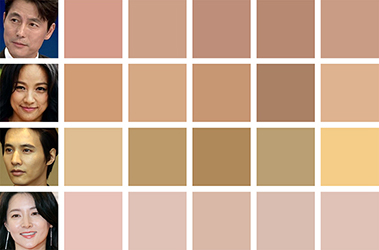

In [40]:
print("참고용 이미지 : 볼 - 턱 - 얼굴 - 눈 - 이마")
Image("img/참고용 이미지_볼-턱-얼굴-눈-이마.jpg")

In [23]:
# 측색 안면부위 설문결과 (모집단 분리하지 않은 항목) 데이터 준비

## 밝은색 설문 결과 불러오기
face1 = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (1).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="I, J, K, L")
face1.rename(columns={face1.columns[0]:"region 1",
                          face1.columns[1]:"region 2",
                          face1.columns[2]:"region 3",
                          face1.columns[3]:"region 4"}, inplace=True)

## 조화색 설문 결과 불러오기
face2 = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (2).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="I, J, K, L")
face2.rename(columns={face2.columns[0]:"region 1",
                          face2.columns[1]:"region 2",
                          face2.columns[2]:"region 3",
                          face2.columns[3]:"region 4"}, inplace=True)


## 두 결과 합치기
face = pd.concat([face1, face2], join='outer')


## 인덱스 조정
face.reset_index(inplace=True)
del face['index']


## 중복 결과값 분리
region1, region2, region3, region4 = [], [], [], []
for i in range(int(face.shape[0])):
    region1.append(face["region 1"][i].split()[0])
    region1.append(face["region 1"][i].split()[1])
    
    region2.append(face["region 2"][i].split()[0])
    region2.append(face["region 2"][i].split()[1])
    
    region3.append(face["region 3"][i].split()[0])
    region3.append(face["region 3"][i].split()[1])
    
    region4.append(face["region 4"][i].split()[0])
    region4.append(face["region 4"][i].split()[1])


## 리스트 값으로 데이터프레임 작성
face_region = pd.DataFrame()
face_region["region 1"] = region1
face_region["region 2"] = region2
face_region["region 3"] = region3
face_region["region 4"] = region4


# 선택항목 별 부위 매칭 (①-cheek, ②-chin, ③-face, ④-eyes, ⑤-forehead)
columns = ["region 1", "region 2", "region 3", "region 4"]

for i in range(int(face_region.shape[0])):
    for col in columns:
        if face_region[col][i] == "①":
            face_region[col][i] = "cheek"
        elif face_region[col][i] == "②":
            face_region[col][i] = "chin"
        elif face_region[col][i] == "③":
            face_region[col][i] = "face"
        elif face_region[col][i] == "④":
            face_region[col][i] = "eyes"
        else:
            face_region[col][i] = "forehead"

face_region.tail()

,region 1,region 2,region 3,region 4
253,forehead,face,forehead,forehead
254,cheek,cheek,cheek,cheek
255,face,face,forehead,forehead
256,chin,face,chin,cheek
257,forehead,forehead,eyes,chin


In [95]:
# 기본항목 전처리 결과 저장
face_region.to_csv("data/face_region.csv")

### 색고정, 명도/채도변경 팔레트 설문결과 전처리

참고용 이미지 : S-5/V-5 - S-5/V+5 - original - S+5/V+5 S+5/V-5


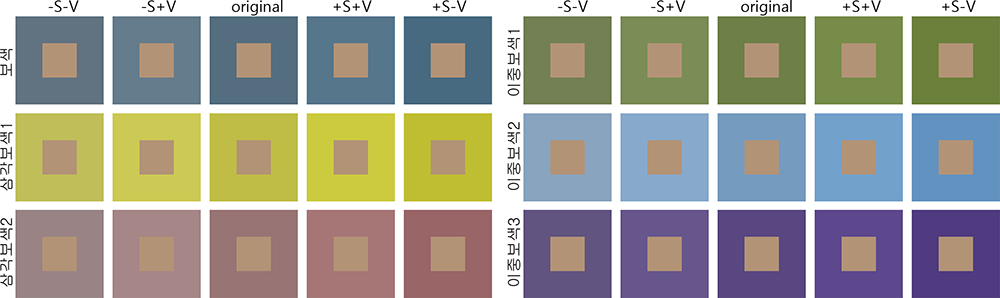

In [43]:
print("참고용 이미지 : S-5/V-5 - S-5/V+5 - original - S+5/V+5 S+5/V-5")
Image("img/참고용 이미지_색고정.jpg")

In [29]:
# 팔레트 설문결과 (모집단 분리한 항목) 데이터 준비

## 밝은색 설문 결과 불러오기
hueFixed_bright = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (1).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="M, N, O, P, Q, R")
hueFixed_bright.rename(columns={hueFixed_bright.columns[0]:"comp",
                                hueFixed_bright.columns[1]:"triangle1",
                                hueFixed_bright.columns[2]:"triangle2",
                                hueFixed_bright.columns[3]:"doubleness1",
                                hueFixed_bright.columns[4]:"doubleness2",
                                hueFixed_bright.columns[5]:"doubleness3"}, inplace=True)
hueFixed_bright["class"] = "bright"
columns = ["comp", "triangle1", "triangle2", "doubleness1", "doubleness2", "doubleness3"]


## 선택항목 별 부위 매칭 (①-채도(-5)/명도(-5), ②-채도(-5)/명도(+5), ③-original, ④-채도(+5)/명도(+5), ⑤-채도(+5)/명도(-5))
for i in range(int(hueFixed_bright.shape[0])):
    for col in columns:
        if hueFixed_bright[col][i] == "①":
            hueFixed_bright[col][i] = "-S-V"
        elif hueFixed_bright[col][i] == "②":
            hueFixed_bright[col][i] = "-S+V"
        elif hueFixed_bright[col][i] == "③":
            hueFixed_bright[col][i] = "original"
        elif hueFixed_bright[col][i] == "④":
            hueFixed_bright[col][i] = "+S+V"
        else:
            hueFixed_bright[col][i] = "+S-V"



## 조화색 설문 결과 불러오기
hueFixed_harmony = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (2).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="M, N, O, P, Q, R")
hueFixed_harmony.rename(columns={hueFixed_harmony.columns[0]:"comp",
                                hueFixed_harmony.columns[1]:"triangle1",
                                hueFixed_harmony.columns[2]:"triangle2",
                                hueFixed_harmony.columns[3]:"doubleness1",
                                hueFixed_harmony.columns[4]:"doubleness2",
                                hueFixed_harmony.columns[5]:"doubleness3"}, inplace=True)
hueFixed_harmony["class"] = "harmony"


## 선택항목 별 부위 매칭 (①-채도(-5)/명도(-5), ②-채도(-5)/명도(+5), ③-original, ④-채도(+5)/명도(+5), ⑤-채도(+5)/명도(-5))
for i in range(int(hueFixed_harmony.shape[0])):
    for col in columns:
        if hueFixed_harmony[col][i] == "①":
            hueFixed_harmony[col][i] = "-S-V"
        elif hueFixed_harmony[col][i] == "②":
            hueFixed_harmony[col][i] = "-S+V"
        elif hueFixed_harmony[col][i] == "③":
            hueFixed_harmony[col][i] = "original"
        elif hueFixed_harmony[col][i] == "④":
            hueFixed_harmony[col][i] = "+S+V"
        else:
            hueFixed_harmony[col][i] = "+S-V"

## 데이터프레임 합치기
hueFixed = pd.concat([hueFixed_bright, hueFixed_harmony], join='outer')

## 인덱스 조정
hueFixed.reset_index(inplace=True)
del hueFixed['index']

hueFixed

,comp,triangle1,triangle2,doubleness1,doubleness2,doubleness3,class
0,-S+V,+S+V,-S+V,+S+V,+S+V,-S+V,bright
1,+S+V,-S+V,+S-V,-S+V,original,+S+V,bright
2,+S-V,+S+V,+S+V,original,-S+V,+S+V,bright
3,-S+V,+S+V,-S+V,-S+V,+S+V,+S+V,bright
4,-S+V,+S+V,-S+V,+S+V,-S+V,-S+V,bright
...,...,...,...,...,...,...,...
124,+S+V,+S+V,original,-S+V,-S+V,-S+V,harmony
125,-S+V,+S+V,original,-S-V,-S-V,-S-V,harmony
126,-S+V,+S+V,+S-V,+S-V,-S+V,original,harmony
127,+S-V,+S+V,+S-V,original,+S-V,+S-V,harmony


In [ ]:
# 기본항목 전처리 결과 저장
hueFixed.to_csv("data/hueFixed.csv")

### 색변경, 명도/채도고정 팔레트 설문결과 전처리

참고용 이미지 : 색+72º - 색+144º - original - 색+216º - 색+288º


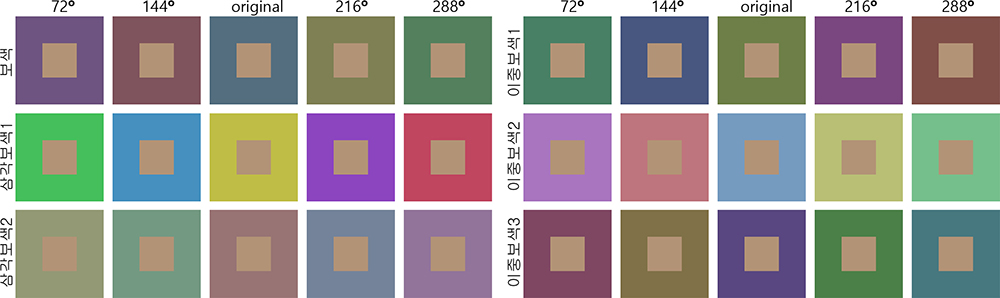

In [42]:
print("참고용 이미지 : 색+72º - 색+144º - original - 색+216º - 색+288º")
Image("img/참고용 이미지_색변경.jpg")

In [28]:
# 팔레트 설문결과 (모집단 분리한 항목) 데이터 준비

## 밝은색 설문 결과 불러오기
hueChanged_bright = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (1).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="S, T, U, V, W, X")
hueChanged_bright.rename(columns={hueChanged_bright.columns[0]:"comp",
                                hueChanged_bright.columns[1]:"triangle1",
                                hueChanged_bright.columns[2]:"triangle2",
                                hueChanged_bright.columns[3]:"doubleness1",
                                hueChanged_bright.columns[4]:"doubleness2",
                                hueChanged_bright.columns[5]:"doubleness3"}, inplace=True)
hueChanged_bright["class"] = "bright"
columns = ["comp", "triangle1", "triangle2", "doubleness1", "doubleness2", "doubleness3"]


## 선택항목 별 부위 매칭 (①-색+72º, ②-색+144º, ③-original, ④-색+216º, ⑤-색+288º)
for i in range(int(hueChanged_bright.shape[0])):
    for col in columns:
        if hueChanged_bright[col][i] == "①":
            hueChanged_bright[col][i] = "72"
        elif hueChanged_bright[col][i] == "②":
            hueChanged_bright[col][i] = "144"
        elif hueChanged_bright[col][i] == "③":
            hueChanged_bright[col][i] = "original"
        elif hueChanged_bright[col][i] == "④":
            hueChanged_bright[col][i] = "216"
        else:
            hueChanged_bright[col][i] = "288"



## 조화색 설문 결과 불러오기
hueChanged_harmony = pd.read_excel("data/퍼스널컬러 정량화 모델 가설검정을 위한 설문 (2).xlsx",
                          sheet_name = 'Sheet1', header=0,na_values = 'NaN',
                          usecols="S, T, U, V, W, X")
hueChanged_harmony.rename(columns={hueChanged_harmony.columns[0]:"comp",
                                hueChanged_harmony.columns[1]:"triangle1",
                                hueChanged_harmony.columns[2]:"triangle2",
                                hueChanged_harmony.columns[3]:"doubleness1",
                                hueChanged_harmony.columns[4]:"doubleness2",
                                hueChanged_harmony.columns[5]:"doubleness3"}, inplace=True)
hueChanged_harmony["class"] = "harmony"


## 선택항목 별 부위 매칭 (①-색+72º, ②-색+144º, ③-original, ④-색+216º, ⑤-색+288º)
for i in range(int(hueChanged_harmony.shape[0])):
    for col in columns:
        if hueChanged_harmony[col][i] == "①":
            hueChanged_harmony[col][i] = "72"
        elif hueChanged_harmony[col][i] == "②":
            hueChanged_harmony[col][i] = "144"
        elif hueChanged_harmony[col][i] == "③":
            hueChanged_harmony[col][i] = "original"
        elif hueChanged_harmony[col][i] == "④":
            hueChanged_harmony[col][i] = "216"
        else:
            hueChanged_harmony[col][i] = "288"

## 데이터프레임 합치기
hueChanged = pd.concat([hueChanged_bright, hueChanged_harmony], join='outer')

## 인덱스 조정
hueChanged.reset_index(inplace=True)
del hueChanged['index']

hueChanged

,comp,triangle1,triangle2,doubleness1,doubleness2,doubleness3,class
0,216,288,144,original,144,144,bright
1,72,72,144,144,original,144,bright
2,144,216,72,144,72,144,bright
3,288,288,216,288,216,72,bright
4,216,144,72,72,144,144,bright
...,...,...,...,...,...,...,...
124,original,original,144,original,144,288,harmony
125,216,288,original,144,216,original,harmony
126,288,216,original,original,144,original,harmony
127,original,216,216,72,72,288,harmony


In [ ]:
# 기본항목 전처리 결과 저장
hueChanged.to_csv("data/hueChanged.csv")

In [ ]:
# 전처리 csv 파일 불러오기

# elementaryItem = pd.read_csv("data/elementaryItem.csv", index_col=0)
# elementaryItem

# face_region = pd.read_csv("data/face_region.csv", index_col=0)
# face_region

# hueFixed = pd.read_csv("data/hueFixed.csv", index_col=0)
# hueFixed

# hueChanged = pd.read_csv("data/hueChanged.csv", index_col=0)
# hueChanged